MS Marco


In [94]:
%load_ext autoreload
%autoreload 2

from data import ms_marco
from collections import Counter
import matplotlib.pyplot as plt

ds = ms_marco.load_ms_marco()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
ds

DatasetDict({
    validation: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 10047
    })
    train: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 82326
    })
    test: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 9650
    })
})

There are a number of queries with not exactly one correct answer in the dataset.

To better prepare the dataset, each item $i$ should be 
- One question $q_i$
- 1 positive passage $p_i^+$
- $n$ irrelevant (negative passages) $p_{i,j}^-$

In [39]:
train_ds = ds['train']

num_selected = []
for idx, row in enumerate(train_ds):
    num_selected.append(sum(row['passages']['is_selected'])) 

Counter({1: 71726, 2: 7254, 0: 2622, 3: 623, 4: 91, 5: 6, 7: 2, 6: 2})


In [51]:
[(i,j/len(num_selected)*100) for i,j in sorted(Counter(num_selected).items())]

[(0, 3.184899059835289),
 (1, 87.12435925467045),
 (2, 8.811311128926464),
 (3, 0.7567475645604063),
 (4, 0.11053616111556495),
 (5, 0.007288098535092194),
 (6, 0.0024293661783640645),
 (7, 0.0024293661783640645)]

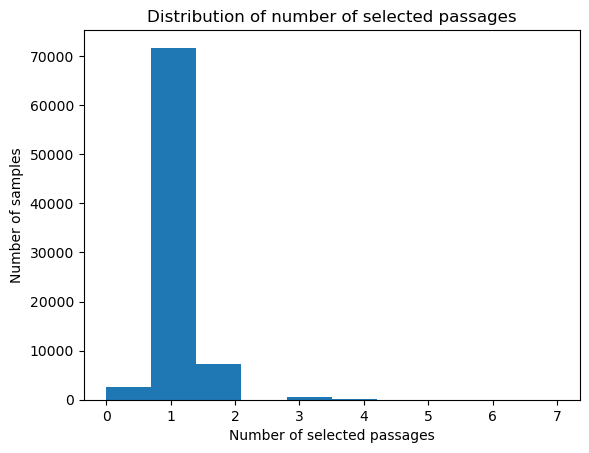

In [38]:
plt.hist(num_selected)
plt.xlabel('Number of selected passages')
plt.ylabel('Number of samples')
plt.title('Distribution of number of selected passages')
plt.show()

We should also aim to give "hard" negatives first, and then get other negatives.

In [60]:
def rows_k_answers(ds, k=1):
    # Returns sorted list of rows with k answers
    num_selected = []
    for idx, row in enumerate(ds):
        num_selected.append(sum(row['passages']['is_selected'])) 

    rows = [i for i, x in enumerate(num_selected) if x == k ]
    return rows


single_correct_rows = rows_k_answers(train_ds, k=1)
len(single_correct_rows)

71726

In [71]:
row

{'answers': ["In a New York State hermit's letter to the editor of an Adirondack Mountain newspaper."],
 'passages': {'is_selected': [1, 0, 0, 0, 0, 0, 0],
  'passage_text': ["The first reference to the phrase, '...it is what it is,' that I've come across is from 1943, in a New York State hermit's letter to the editor of an Adirondack Mountain newspaper. The hermit was named Noah John Rondeau, and he concluded his letter with this particular phrase.",
   'While servant leadership is a timeless concept, the phrase “servant leadership” was coined by Robert K. Greenleaf in The Servant as Leader, an essay that he first published in 1970. In that essay, Greenleaf said:',
   'Related Questions. Who first coined the phrase, You got what you wanted, but you lost what you had or They got what they wanted, but they los... I know that this phrase is included in the Disney movie The Princess and the Frog, but I think it is much older than that.',
   'The phrase is stupid enough when rationalizing 

In [83]:
row['passages']['passage_text'][0]

"The first reference to the phrase, '...it is what it is,' that I've come across is from 1943, in a New York State hermit's letter to the editor of an Adirondack Mountain newspaper. The hermit was named Noah John Rondeau, and he concluded his letter with this particular phrase."

In [90]:
import torch
row = train_ds[single_correct_rows[15]]
is_selected = torch.tensor(row['passages']['is_selected'])
selected_idx = torch.argwhere(is_selected)
negatives_idxs = torch.argwhere(~is_selected)

positive_answer = []
negative_answers = []

for text, is_selected in zip(row['passages']['passage_text'], row['passages']['is_selected']):
    if is_selected:
        positive_answer.append(text)
    else:
        negative_answers.append(text)

6


In [91]:


def get_entry_item(idx):
    row = train_ds[idx]
    query = row['query']

    # Get positive and negative answers
    positive_answer = []
    negative_answers = []   
    for text, is_selected in zip(row['passages']['passage_text'], row['passages']['is_selected']):
        if is_selected:
            positive_answer.append(text)
        else:
            negative_answers.append(text)
    return query, positive_answer, negative_answers

get_entry_item(0)

('what is rba',
 ['Results-Based Accountability® (also known as RBA) is a disciplined way of thinking and taking action that communities can use to improve the lives of children, youth, families, adults and the community as a whole. RBA is also used by organizations to improve the performance of their programs. Creating Community Impact with RBA. Community impact focuses on conditions of well-being for children, families and the community as a whole that a group of leaders is working collectively to improve. For example: “Residents with good jobs,” “Children ready for school,” or “A safe and clean neighborhood”.'],
 ["Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearl

In [92]:
ds['train'][0]

{'answers': ['Results-Based Accountability is a disciplined way of thinking and taking action that communities can use to improve the lives of children, youth, families, adults and the community as a whole.'],
 'passages': {'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
  'passage_text': ["Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site.",
   "The Reserve Bank of Australia (RBA) came into being on 14 January 1960 as Australia 's central bank and banknote issuing authority, when the Reserve Bank Act 1959 removed the central banking functions from the C

In [97]:
train_ds = ms_marco.MSMarcoDataset(split='train')

INFO:data.ms_marco:Loaded train dataset
INFO:data.ms_marco:Selected 71726 rows with 1 answer


In [106]:
train_ds[10]

('how long cooking chicken legs in the big easy',
 ['Directions. 1  Arrange chicken thighs/leg quarters skin side up in a shallow baking dish. 2  Sprinkle with garlic powder. 3  Drizzle about 1/2 teaspoon soy sauce on each piece. 4  Bake at 350 degrees Fahrenheit for 45 minutes to an hour, until the skin is crisp and brown and the meat is ready to fall off the bones.'],
 ['Bake the chicken. Put the chicken in the oven and set a timer for 30 minutes. Check the chicken after 30 minutes. It should be ready when the skin is crispy and golden brown, or when the internal temperature has reached 180 degrees. Use a meat thermometer to check the temperature.',
  "Directions. 1  Put some olive oil in the bottom of a 9X13 pan (just enough to put the drumsticks on). 2  Add drumsticks (space enough apart so they aren't touching each other). 3  Sprinkle generously with pepper and garlic powder. 4  Bake at 375 for half an hour. 5  Bake another half an hour (or until cooked til 160 degrees)).",
  '1 A